# Q. #4

In [1]:
# Import all the functions used in part 1
from era_okid_tools import *
prob = "4-1"

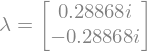

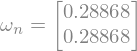

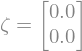

In [2]:
# Set seed for consistent results
rng = np.random.default_rng(seed = 100)

# Simulation dimensions
orders = (15, 30, 60) # Order of OKID algorithm, number of Markov parameters to identify after the zeroeth
cases = 3 # Number of cases
n = 2 # Number of states
r = 1 # Number of inputs
m = 2 # Number of measurements
t_max = 50 # Total simulation time
dt = 0.1 # Simulation timestep duration
nt = int(t_max/dt) # Number of simulation timesteps

# Simulation time
train_cutoff = int(20/dt) + 1
t_sim = np.linspace(0, t_max, nt + 1)
t_train = t_sim[:train_cutoff]
t_test = t_sim
nt_train = train_cutoff
nt_test = nt

# Problem parameters
theta_0 = 0.5 # Angular velocity
k = 10 # Spring stiffness
mass = 1 # Point mass

# State space model
A_c = np.array([[0, 1], [theta_0**2 - k/mass, 0]])
B_c = np.array([[0], [1]])
C = np.eye(2)
D = np.array([[0], [1]])
A, B = c2d(A_c, B_c, dt)
eig_A = spla.eig(A_c)[0] # Eigenvalues of true system
etch(f"\lambda", eig_A)
etch(f"\omega_{{n}}", np.abs(eig_A))
etch(f"\zeta", -np.cos(np.angle(eig_A)))

# True simulation values
X_0_sim = np.zeros([n, 1]) # Zero initial condition
U_sim = np.zeros([cases, r, nt]) # True input vectors
U_sim[0] = rng.normal(0, 0.1, [r, nt]) # True input for case 1
U_sim[1] = spsg.square(2*np.pi*5*t_sim[:-1]) # True input for case 2
U_sim[2] = np.cos(2*np.pi*2*t_sim[:-1]) # True input for case 3
X_sim = np.zeros([cases, n, nt + 1]) # True state vectors
Z_sim = np.zeros([cases, m, nt]) # True observation vectors
W_sim = np.zeros([len(orders), cases, m, nt]) # Measurement noise vectors

# Separation into train and test data
U_train = U_sim[0, :r, :train_cutoff] # Train input vector
U_test = U_sim # Test input vectors
X_train = np.zeros([len(orders), n, nt_train]) # Train state vector
X_test = np.zeros([len(orders), cases, n, nt_test + 1]) # Test state vectors
Z_train = np.zeros([len(orders), m, nt_train]) # Train observation vector
Z_test = np.zeros([len(orders), cases, m, nt_test]) # Test observation vectors

In [3]:
# OKID logistics
alpha, beta = 3, 3 # Number of block rows and columns in Hankel matrices
n_era = 2 # Number of proposed states
X_0_okid = np.zeros([n_era, 1]) # Zero initial condition

Note that we have set $\alpha = 3$ and $\beta = 3$ for this simulation.
We choose $l_0 = \{15, 30, 60\}$ to determine the effect of
observer order on the results of the system identification.

In [4]:
# OKID state vector, drawn from state space model derived from OKID/ERA
X_okid_train = np.zeros([len(orders), n_era, nt_train + 1])
X_okid_test = np.zeros([len(orders), cases, n_era, nt_test + 1])
# OKID observations, drawn from state space model derived from OKID/ERA
Z_okid_train = np.zeros([len(orders), n_era, nt_train])
Z_okid_test = np.zeros([len(orders), cases, n_era, nt_test])
# Singular values of the Hankel matrix constructed through OKID Markov parameters
S_okid = np.zeros([len(orders), min(alpha*m, beta*r)])
eig_A_okid = np.zeros([len(orders), n_era], dtype = complex)

A_okid = np.zeros([len(orders), n_era, n_era])
B_okid = np.zeros([len(orders), n_era, r])
C_okid = np.zeros([len(orders), m, n_era])
D_okid = np.zeros([len(orders), m, r])
G_okid = np.zeros([len(orders), m, m])

Rank of H(0): 3
Rank of H(1): 3
Rank of H(0): 3
Rank of H(1): 2
Rank of H(0): 2
Rank of H(1): 2


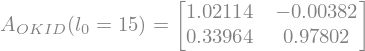

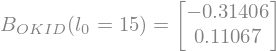

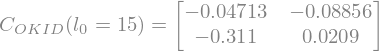

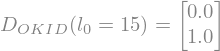

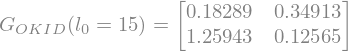

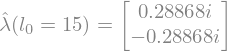

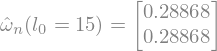

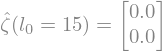

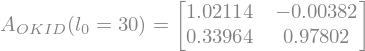

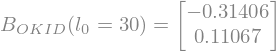

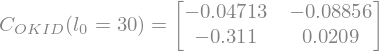

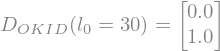

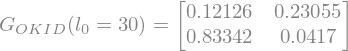

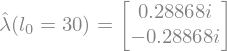

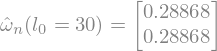

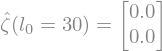

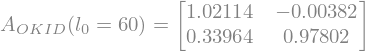

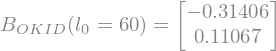

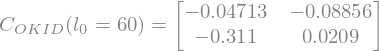

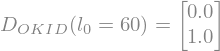

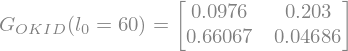

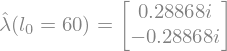

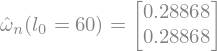

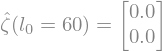

In [5]:
# Simulation
for i, j in it.product(range(cases), range(len(orders))):
    X_sim[i], Z_sim[i] = sim_ss(A, B, C, D, X_0 = X_0_sim, U = U_sim[i], nt = nt)
    if i == 0:
        # Split between train and test data for case 1
        X_train[j], Z_train[j] = \
            X_sim[i, :, :train_cutoff], Z_sim[i, :, :train_cutoff]
        # Identify System Markov parameters and Observer Gain Markov parameters
        Y_okid, Y_og_okid = \
            okid(Z_train[j], U_train,
                 l_0 = orders[j], alpha = alpha, beta = beta, n = n_era)
        # Identify state space model using System Markov parameters for ERA
        A_okid[j], B_okid[j], C_okid[j], D_okid[j], S_okid[j] = \
            era(Y_okid, alpha = alpha, beta = beta, n = n_era)
        # Construct observability matrix
        O_p_okid = np.array([C_okid[j] @ np.linalg.matrix_power(A_okid[j], i)
                             for i in range(orders[j])])
        # Find observer gain matrix
        G_okid[j] = spla.pinv2(O_p_okid.reshape([orders[j]*m, n_era])) @ Y_og_okid.reshape([orders[j]*m, m])
        X_okid_train[j], Z_okid_train[j] = \
            sim_ss(A_okid[j], B_okid[j], C_okid[j], D_okid[j],
                   X_0 = X_0_okid, U = U_train, nt = nt_train)
        # Display outputs
        etch(f"A_{{OKID}}(l_0 = {orders[j]})", A_okid[j])
        etch(f"B_{{OKID}}(l_0 = {orders[j]})", B_okid[j])
        etch(f"C_{{OKID}}(l_0 = {orders[j]})", C_okid[j])
        etch(f"D_{{OKID}}(l_0 = {orders[j]})", D_okid[j])
        etch(f"G_{{OKID}}(l_0 = {orders[j]})", G_okid[j])
        # Calculate and display eigenvalues
        eig_A_okid[j] = spla.eig(d2c(A_okid[j], B_okid[j], dt)[0])[0] # Eigenvalues of identified system
        etch(f"\hat{{\lambda}}(l_0 = {orders[j]})", eig_A_okid[j])
        etch(f"\hat{{\omega}}_{{n}}(l_0 = {orders[j]})", np.abs(eig_A_okid[j]))
        etch(f"\hat{{\zeta}}(l_0 = {orders[j]})", -np.cos(np.angle(eig_A_okid[j])))
    X_test[j, i], Z_test[j, i] = \
        X_sim[i], Z_sim[i]
    X_okid_test[j, i], Z_okid_test[j, i] = \
        sim_ss(A_okid[j], B_okid[j], C_okid[j], D_okid[j],
               X_0 = X_0_okid, U = U_test[i], nt = nt_test)

In the absence of noise, regardless of the order selected,
the eigenvalues, natural frequencies, and the system as a whole are
able to be identified essentially perfectly.

In [6]:
RMS_train = np.zeros([len(orders), m])
RMS_test = np.zeros([len(orders), cases, m])
for j in range(len(orders)):
    RMS_train[j] = np.sqrt(np.mean((Z_okid_train[j] - Z_train[j])**2, axis = 1))
    print(f"RMS Error of sim. for system found via OKID for train data, order = {orders[j]}: {RMS_train[j]}")
    for i in range(cases):
        RMS_test[j, i] = np.sqrt(np.mean((Z_okid_test[j, i] - Z_test[j, i])**2, axis = 1))
        print(f"RMS Error of sim. for system found via OKID for test data, order = {orders[j]}, case {i}: {RMS_test[j, i]}")

RMS Error of sim. for system found via OKID for train data, order = 15: [3.05296520e-13 6.67059835e-14]
RMS Error of sim. for system found via OKID for test data, order = 15, case 0: [1.75757982e-12 4.34163798e-13]
RMS Error of sim. for system found via OKID for test data, order = 15, case 1: [2.66808800e-11 8.96747723e-12]
RMS Error of sim. for system found via OKID for test data, order = 15, case 2: [1.00246300e-12 3.03201052e-13]
RMS Error of sim. for system found via OKID for train data, order = 30: [1.29016426e-13 2.89262837e-14]
RMS Error of sim. for system found via OKID for test data, order = 30, case 0: [7.92475271e-13 1.84851715e-13]
RMS Error of sim. for system found via OKID for test data, order = 30, case 1: [1.24637972e-11 3.83375661e-12]
RMS Error of sim. for system found via OKID for test data, order = 30, case 2: [4.31230688e-13 1.34062259e-13]
RMS Error of sim. for system found via OKID for train data, order = 60: [1.83371465e-14 6.65752871e-15]
RMS Error of sim. for 

The RMS error for the test cases is essentially zero regardless of order.

In [7]:
# Eigenvalue plots
fig, ax = plt.subplots(constrained_layout = True) # type:figure.Figure
fig.suptitle(f"[{prob}] Eigenvalues", fontweight = "bold")

ax.plot(np.real(eig_A), np.imag(eig_A),
         "o", mfc = "None")
for j in range(len(orders)):
    ax.plot(np.real(eig_A_okid[j]), np.imag(eig_A_okid[j]),
            "o", mfc = "None")

fig.legend(labels = ("True", *[f"OKID ($l_0$ = {q})" for q in orders]),
           bbox_to_anchor = (1, 0.5), loc = 6)
fig.savefig(figs_dir / f"midterm_{prob}_eigval.pdf",
            bbox_inches = "tight")

# Singular Value plots
fig, ax = plt.subplots(constrained_layout = True) # type:figure.Figure
fig.suptitle(f"[{prob}] Singular Values", fontweight = "bold")

for j in range(len(orders)):
    ax.plot(np.linspace(1, len(S_okid[j]), len(S_okid[j])), S_okid[j],
            "o", mfc = "None")
plt.setp(ax, xlabel = f"Singular Value", ylabel = f"Value",
         xticks = np.arange(1, S_okid.shape[-1] + 1))

fig.legend(labels = [f"OKID ($l_0$ = {q})" for q in orders],
           bbox_to_anchor = (1, 0.5), loc = 6)
fig.savefig(figs_dir / f"midterm_{prob}_singval.pdf",
            bbox_inches = "tight")

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

The singular values essentially do not change as the observer order is varied.

In [8]:
# Observation plots
ms = 0.5
for i, k in it.product(range(cases), range(len(orders))):
    # Raw observations
    raw_fig, axs = plt.subplots(m, 1,
                                sharex = "col", constrained_layout = True) # type:figure.Figure
    raw_fig.suptitle(f"[{prob}] Observation Responses (Case {i + 1})\n$l_0$ = {orders[k]}",
                     fontweight = "bold")
    if i == 0:
        for j in range(m):
            axs[j].plot(t_sim[:-1], Z_sim[i, j])
            axs[j].plot(t_train, Z_train[k, j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[train_cutoff:-1], Z_test[k, i, j, train_cutoff:],
                        "s", ms = ms, mfc = "None")
            axs[j].plot(t_train, Z_okid_train[k, j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[train_cutoff:-1], Z_okid_test[k, i, j, train_cutoff:],
                        "D", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        raw_fig.legend(labels = ["True", "Train", "Test",
                                 "OKID\n(Train)", "OKID\n(Test)"],
                       bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        for j in range(m):
            axs[j].plot(t_sim[:-1], Z_sim[i, j])
            axs[j].plot(t_test[:-1], Z_test[k, i, j],
                        "o", ms = ms, mfc = "None")
            axs[j].plot(t_test[:-1], Z_okid_test[k, i, j],
                        "s", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        raw_fig.legend(labels = ["True", "Test", "OKID\nTest"],
                       bbox_to_anchor = (1, 0.5), loc = 6)
    raw_fig.savefig(figs_dir / f"midterm_{prob}_obs_case{i + 1}_order{k}.pdf",
                    bbox_inches = "tight")

    # Observation error
    err_fig, axs = plt.subplots(m, 1,
                                sharex = "col", constrained_layout = True) # type:figure.Figure
    err_fig.suptitle(f"[{prob}] Observation Error (Case {i + 1})\n$l_0$ = {orders[k]}",
                     fontweight = "bold")
    if i == 0:
        for j in range(m):
            axs[j].plot(t_train, np.abs(Z_okid_train[k, j] - Z_train[k, j]),
                        c = "C1")
            axs[j].plot(t_test[train_cutoff:-1], np.abs(Z_okid_test[k, i, j, train_cutoff:] - Z_test[k, i, j, train_cutoff:]),
                        "o", ms = ms, mfc = "None", c = "C0")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        err_fig.legend(labels = ["OKID\nTrain", "OKID\nTest"],
                       bbox_to_anchor = (1, 0.5), loc = 6)
    else:
        for j in range(m):
            axs[j].plot(t_test[:-1], np.abs(Z_okid_test[k, i, j] - Z_test[k, i, j]),
                        "o", ms = ms, mfc = "None")
            plt.setp(axs[j], ylabel = f"$z_{j}$",
                     xlim = [0, t_max])
            if j == (m - 1):
                plt.setp(axs[j], xlabel = f"Time")
        err_fig.legend(labels = ["OKID\nTest"],
                       bbox_to_anchor = (1, 0.5), loc = 6)
    err_fig.savefig(figs_dir / f"midterm_{prob}_obs-error_case{i + 1}_order{k}.pdf",
                    bbox_inches = "tight")

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

<Figure size 640x480 with 2 Axes>

The estimation is flawless regardless of the observer order chosen.
In this case where there is no noise,
we conclude that lowering or highering the observer order,
as long as it falls within the necessary
boundaries, does not have any practical negative impact on the
high accuracy of the identification of this simple system.